In [4]:
import numpy as np
import tensorflow as tf

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
tf.__version__

'1.13.1'

In [7]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [8]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')


In [9]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [10]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [12]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [13]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 20) dtype=float32>)

In [14]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [15]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

In [16]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
import helpers


In [19]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[1 7 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [20]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[6, 6, 4, 7]
[9, 8, 2]
[4, 2, 3, 7]
[3, 7, 6, 6, 9, 9]
[7, 9, 5]
[5, 8, 5]
[3, 4, 8]
[2, 5, 2, 4]
[5, 5, 4, 8, 4, 7, 9, 8]
[9, 6, 2, 7]


In [21]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [22]:
loss_track = []


In [23]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.1690807342529297
  sample 1:
    input     > [6 6 5 3 0 0 0 0]
    predicted > [7 7 7 7 7 0 0 0 0]
  sample 2:
    input     > [5 5 4 2 9 4 4 6]
    predicted > [7 0 0 0 4 0 0 0 0]
  sample 3:
    input     > [2 9 6 0 0 0 0 0]
    predicted > [1 7 7 7 7 0 0 0 0]

batch 1000
  minibatch loss: 0.29293426871299744
  sample 1:
    input     > [6 6 9 4 0 0 0 0]
    predicted > [6 6 9 4 1 0 0 0 0]
  sample 2:
    input     > [8 2 9 0 0 0 0 0]
    predicted > [8 2 9 1 0 0 0 0 0]
  sample 3:
    input     > [8 2 3 8 0 0 0 0]
    predicted > [8 2 3 8 1 0 0 0 0]

batch 2000
  minibatch loss: 0.1797865629196167
  sample 1:
    input     > [9 5 9 0 0 0 0 0]
    predicted > [9 5 9 1 0 0 0 0 0]
  sample 2:
    input     > [8 8 5 7 0 0 0 0]
    predicted > [8 8 5 7 1 0 0 0 0]
  sample 3:
    input     > [8 2 8 6 8 9 7 0]
    predicted > [8 8 8 6 8 9 7 1 0]

batch 3000
  minibatch loss: 0.104561448097229
  sample 1:
    input     > [4 6 8 2 0 0 0 0]
    predicted > [4 6 8 2

loss 0.1188 after 300100 examples (batch_size=100)


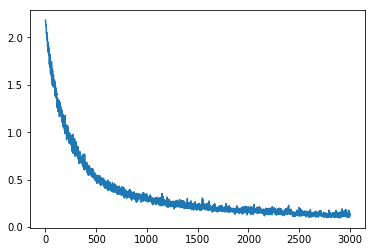

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))